In [ ]:
%load_ext autoreload
%autoreload 2


import random

import numpy as np
import matplotlib.pyplot as plt

import glob
import os

from autoscript_sdb_microscope_client.structures import AdornedImage

from fibsem import calibration, utils, movement, milling, config, structures
from liftout import utils as l_utils 
from liftout.detection import detection

from pprint import pprint

import scipy.ndimage as ndi
import skimage

from liftout.detection.DetectionModel import DetectionModel
from liftout.detection.detection import DetectionType
from liftout.detection import utils as det_utils

from fibsem.structures import Point



### Land Lamella on Post

In [ ]:
# Step
## align_lamella_to_centre_landing_post_ib

sample = "**"
_id = "*"
img_type = "_ib"
search = "landing_needle_land_sample_*"
filenames = glob.glob(f"data/{sample}/{_id}/*{search}{img_type}.tif") 
random.shuffle(filenames)

print(f"{len(filenames)} selected.")

for fname in filenames:
    img = AdornedImage.load(fname)
    
    print(f"{os.path.basename(fname)}, beam: {img.metadata.acquisition.beam_type}")
  
    det = detection.locate_shift_between_features_v2(img, None, shift_type=(DetectionType.LamellaEdge, DetectionType.LandingPost))

    fig = det_utils.plot_detection_result(det)
    plt.show()
    plt.close(fig)




### Needle Insertion Entry Alignment

In [ ]:

## TODO: BETTER LANDING ENTRY

# 1. take image before inserting
# 2. insert needle lower in eb
# 3. take difference between two images
# 4. detect needle position from difference image
# 5. detect landing post from centroid


# only use if we cant make the needle insert lower into the void area
# if we cant 






filenames = []

# landing
sample = "dm*"
_id = "*"

img_type = "label"
search = "landing_needle_land_sample_lowres_"
label_filenames = glob.glob(f"data/{sample}/{_id}/*{search}{img_type}.tif") 
random.shuffle(filenames)


for fname in label_filenames:

    base = os.path.dirname(fname)
    lower_fname = glob.glob(f"{base}/{search}eb.tif")[0]
    filenames.append((fname, lower_fname))


# liftout initial
sample = "*"
_id = "*"
img_type = "_*b"
search = "needle_liftout_initial_position"
label_filenames2 = glob.glob(f"data/{sample}/{_id}/*{search}{img_type}.tif") 


for fname in label_filenames2:

    base = os.path.dirname(fname)
    img_type = "eb" if "eb" in os.path.basename(fname) else "ib"
    search = "needle_liftout_start_position_lowres_"
    lower_fname = glob.glob(f"{base}/{search}{img_type}.tif")[0]

    filenames.append((fname, lower_fname))


# liftout
sample = "*"
_id = "*"
img_type = "_eb"
search = "needle_liftout_start_position_lowres"
label_filenames3 = glob.glob(f"data/{sample}/{_id}/*{search}{img_type}.tif") 


for fname in label_filenames3:

    base = os.path.dirname(fname)
    img_type = "eb" if "eb" in os.path.basename(fname) else "ib"
    search = "needle_liftout_pre_movement_lowres_"
    lower_fname = glob.glob(f"{base}/{search}{img_type}.tif")[0]

    filenames.append((fname, lower_fname))

## Charging a problem
# - take images to drain the charge?

print(f"{len(filenames)} filenames")

for fname in filenames:

    pprint(fname)

    ref_image = AdornedImage.load(fname[0])
    new_image = AdornedImage.load(fname[1])

    # fig, ax = plt.subplots(1, 2, figsize=(30, 30))
    # ax[0].imshow(ref_image.data, cmap="gray")
    # ax[1].imshow(new_image.data, cmap="gray")
    # plt.show()

    if "landing" in fname[0]:
        det = detection.locate_shift_between_features_v2(new_image, ref_image, shift_type=(DetectionType.NeedleTip, DetectionType.LandingPost), settings=settings)
        det.display_image = ref_image.data
    
    if "initial" in fname[0]:
        det = detection.locate_shift_between_features_v2(new_image, ref_image, shift_type=(DetectionType.NeedleTip, DetectionType.ImageCentre), settings=settings)
        det.display_image = new_image.data
    
    # if "start" in fname[0]:
    #     det = detection.locate_shift_between_features_v2(new_image, ref_image, shift_type=(DetectionType.NeedleTip, DetectionType.ImageCentre), settings=settings)
    #     det.display_image = new_image.data
    

    fig = det_utils.plot_detection_result(det)
    plt.show()
    plt.close(fig)

In [ ]:
# TODO: START_HERE
# need to track the needle as it moves?
# get postion -> get movement -> new position = initial guess
# use previous new image as ref?

# TODO: initial position guess for each beam?
# how to transport around?
# settings dict?





# calibration window (select initial coordinates?)


# how to incorporate the difference images into hte workflow
# refactor locate_shift_between_features_v2 (no model)
#       - use ref_image? could be useful for lamella centre as well..
#       - use a reference for detecting the lamella centre

stage, movement,goal, rate, note, implemented,step

1. util, eucentric_correction, correct the eucentric alignment for both beams
2. trench, align_to_ref_lamella, align the image to the  lamella position selected
3. jcut, align_to_ref_trench, align the image to the lamella trench reference image
4. jcut, align_to_ref_trench_tilt, align the image to the lamella trench reference image after tilting to jcut angle
5. jcut, align_to_ref_jcut_tilt, align the image tot the jcut reference after tilting back to flat to ebeam,
6. liftout, align_to_ref_jcut, align the image to the jcut reference image (flat to ebeam)
7. liftout, align_needle_to_lamella_centre_eb, align the needle to the centre of the lamella (eb, xy)
8. liftout, land_needle_on_lamella_centre_ib, move the needle down until contact is made with the lamella (detect brightness change) 
9. liftout, align_jcut_sever_to_lamella, align the jcut severing cut based on the image centre and lamella size
10. landing, align_needle_to_landing_post_centre_eb, "align the needle to the centre of the landing post (eb, xy)
11. landing, check_lamella_on_needle_ib, validate whether the lamella is attached to the needle
12. landing, land_lamella_on_post_ib, move the needle (x) until it makes contact with the landing post (edges overlap?)
13. landing, align_weld_to_post, align the weld to the intersection of the landing post and the lamella edge
14. landing, align_needle_cut_ib, align the pattern to cut the needle from the lamella
15. reset, align_needle_to_image_centre_ib, align the needle to the centre of the image 
16. thin, align_lamella_centre_to_image_centre_ib, align the centre of the lamella to the centre of the image
17. polsih, align_to_ref_thin_lamella, align the image to the thin lamella reference image

In [ ]:
# create mask from initial area

img = AdornedImage.load("../test_image.tif")
from liftout.utils import load_full_config
settings = load_full_config()

c = Point(
    x=int(img.data.shape[1] * 0.5), 
    y=int(img.data.shape[0] * 0.5)
    )

# w, h = 350, 400

# mask = calibration.create_rect_mask(img.data, c, w, h, sigma=9)

mask = calibration.create_lamella_mask(img, settings, circ=False)
# lamella_edge = detection.detect_lamella_edge(img)

# print(lamella_edge)

fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(img.data, cmap="gray")
ax[0].plot(c.x, c.y, color="lime", marker="+", ms=50, markeredgewidth=2)
ax[1].imshow(mask, cmap="gray")
ax[2].imshow(calibration.normalise_image(img.data) * mask, cmap="gray")
plt.show()



# get initial detection
# get updated position
# use update postion as initial guess for next (after movement?)
# dont think we need this if it moves well enough??



In [ ]:

# cross correlate and plot
shift = AdornedImage(data=np.roll(img.data, shift=(100, 100), axis=(0, 1)), metadata=img.metadata)

from liftout import utils
utils.crosscorrelate_and_plot(img, shift)


In [ ]:

# test images from dm*/*af

# Example Aligning Across Tilt / Different Image
ref_image = AdornedImage.load("../tilt_image_0.tif") # flat_ib, ib
new_image = AdornedImage.load("../tilt_image_1.tif") # flat_eb+6deg, eb

ref_image = AdornedImage(data=np.roll(ref_image.data, shift=(60, 90), axis=(0, 1)), metadata=ref_image.metadata)

from liftout import utils
utils.crosscorrelate_and_plot(ref_image, new_image, rotate=True)

In [ ]:

# Example Aligning Across Tilt / Different Image
ref_image = AdornedImage.load("../tilt_image_2.tif") # flat_eb+6, eb
new_image = AdornedImage.load("../tilt_image_3.tif") # flat_eb, eb

ref_image = AdornedImage(data=np.roll(ref_image.data, shift=(-70, -10), axis=(0, 1)), metadata=ref_image.metadata)

from liftout import utils
utils.crosscorrelate_and_plot(ref_image, new_image, rotate=False)

In [ ]:

# test images from dm*/*af

# Example Aligning Across Tilt / Different Image
ref_image = AdornedImage.load("../tilt_image_4.tif") # flat_ib, ib
new_image = AdornedImage.load("../tilt_image_5.tif") # flat_ib, eb

ref_image = AdornedImage(data=np.roll(ref_image.data, shift=(60, 90), axis=(0, 1)), metadata=ref_image.metadata)

# +25 tilt?

new_image = calibration.cosine_stretch(new_image, 25)
print("------------")

from liftout import utils
utils.crosscorrelate_and_plot(ref_image, new_image, rotate=False)

In [ ]:

# test images from dm*/*708

# Example Aligning Across Tilt / Different Image
ref_image = AdornedImage.load("../tilt_image_6.tif") # flat_ib, ib
new_image = AdornedImage.load("../tilt_image_7.tif") # flat_ib, eb

ref_image = AdornedImage(data=np.roll(ref_image.data, shift=(120, 200), axis=(0, 1)), metadata=ref_image.metadata)

# +25 tilt?
new_image = calibration.cosine_stretch(new_image, 25)

print("------------")

from liftout import utils
utils.crosscorrelate_and_plot(ref_image, new_image, rotate=False)

In [ ]:
# needle moves
# test images from dm*/*af

# Example Aligning Across Tilt / Different Image
ref_image = AdornedImage.load("../needle_image_0.tif") # flat_ib, ib
new_image = AdornedImage.load("../needle_image_1.tif") # flat_ib, eb

# ref mask
initial_point = Point(200, 180)
mask = calibration.create_rect_mask(ref_image.data,initial_point , w=100, h=80, sigma=3)
plt.imshow(ref_image.data * mask, cmap="gray")
plt.show()

print("------------")

from liftout import utils
utils.crosscorrelate_and_plot(ref_image, new_image, rotate=False, ref_mask=mask)

In [ ]:
edge = detection.edge_detection(new_image.data, sigma=3)

updated_point = Point(initial_point.x + 555, initial_point.y+488)
mask = calibration.create_rect_mask(ref_image.data, updated_point, w=100, h=100, sigma=3)
edge_mask = edge * mask


# needle = 


needle = detection.detect_closest_edge_v2(edge, updated_point)

plt.imshow(edge, cmap="turbo")
plt.plot(needle.x, needle.y, "r+", ms=50)
plt.show()

In [ ]:
# these are at different hfw... useless

ref_image = AdornedImage.load("../needle_image_x.tif")
minus = calibration.normalise_image(ref_image) - calibration.normalise_image(new_image)

filt = ndi.filters.gaussian_filter(minus, sigma=12)

edge = detection.edge_detection(filt, sigma=3)  # edges

# mask after edge detection
mask = np.ones_like(ref_image.data)

beam_type = ref_image.metadata.acquisition.beam_type
# if beam_type == "Electron":
#     pt = Point(x=int(ref_image.data.shape[1] * 0.3), y=int(ref_image.data.shape[0]*0.3)) # eb mask, top left corner
#     mask[:pt.y, :pt.x] = 1
# if beam_type == "Ion":
#     pt = Point(x=int(ref_image.data.shape[1] * 0.5), y=int(ref_image.data.shape[0]*0.5)) # ib mask, bottom, left corner
#     mask[pt.y:, :pt.x] = 1

edge_mask = edge * mask

if beam_type == "Electron":
    needle = detection.detect_closest_edge_v2(edge_mask, initial_point)  # closest edge  
if beam_type == "Ion":
    needle = detection.detect_right_edge_v2(edge_mask)   # right most edge

# centre = Point(x=ref_image.data.shape[1]//2, y=ref_image.data.shape[0]//2)
# top_needle = detection.detect_closest_edge_v2(edge_mask, Point(x=400, y=200))  # closest edge  
# bottom_needle = detection.detect_closest_edge_v2(edge_mask, centre)  # closest edge  
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(30, 30))
ax[0].imshow(filt, cmap="gray")
ax[1].imshow(minus * mask, cmap="gray")
ax[2].imshow(edge_mask, cmap="turbo", )
plt.show()

In [ ]:
# get initial needle position
# move to centre
# use cross correlation to determine the shift?
# redetect? and move again?


from liftout.detection.detection import DetectionResult





def automatic_movement(img, ref_img, point, mask, shift_type: tuple[DetectionType]) -> DetectionResult:
    """Abstraction for all types of movements..."""
    
    rotate = False
    lp = 128
    hp = 6
    sigma = 6


    # cross correlate

    # rotate ref
    if rotate:
        ref_image = calibration.rotate_AdornedImage(ref_image)

    dx, dy, xcorr = calibration.shift_from_crosscorrelation(
        ref_img, new_image, lowpass=lp, highpass=hp, sigma=sigma, use_rect_mask=True, ref_mask=mask
    )







    pass




##### background detection / filter

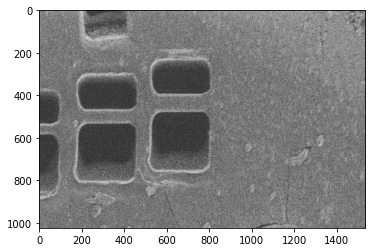

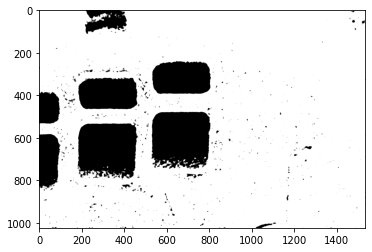

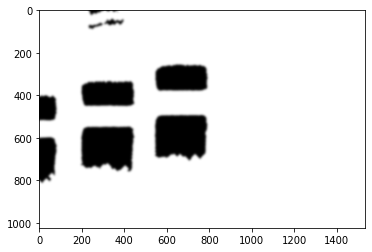

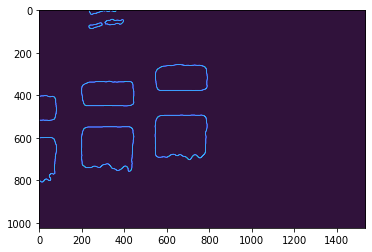

In [10]:
from autoscript_sdb_microscope_client.structures import AdornedImage
import matplotlib.pyplot as plt

from skimage.filters import gaussian, threshold_otsu, median
from skimage.morphology import disk 
from scipy.ndimage.morphology import binary_dilation
import scipy.ndimage as ndi 

import numpy as np

from fibsem.calibration import normalise_image
image = AdornedImage.load("../test_image.tif") 

# mask = np.zeros_like(image.data)
# mask[:400, :300] = 1
mask = np.ones_like(image.data)
masked_image = normalise_image(image) * mask

filt = median(masked_image, disk(5))
thresh = threshold_otsu(filt)
binary = filt > thresh
mask = gaussian(binary_dilation(binary, iterations=15), 5)


from liftout.detection.detection import edge_detection


 

plt.imshow(masked_image, cmap="gray")
plt.show()

plt.imshow(binary, cmap="gray")
plt.show()

plt.imshow(mask, cmap="gray")
plt.show()

plt.imshow(edge_detection(mask), cmap="turbo")
plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


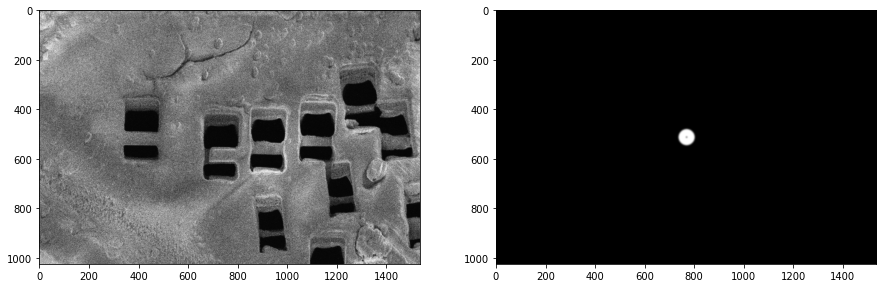

In [28]:
### Lamella size based filters / masks
%load_ext autoreload
%autoreload 2
from liftout import utils
from fibsem import calibration
from pprint import pprint
from scipy import fftpack
settings = utils.load_full_config()


FACTOR = 2

img = AdornedImage.load("../tilt_image_3.tif")
mask = calibration.create_lamella_mask(img, settings, factor=FACTOR, use_trench_height=False)

bandpass = calibration.bandpass_mask((img.data.shape[1], img.data.shape[0]))

fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(img.data, cmap="gray")
ax[1].imshow(bandpass, cmap="gray")
plt.show()

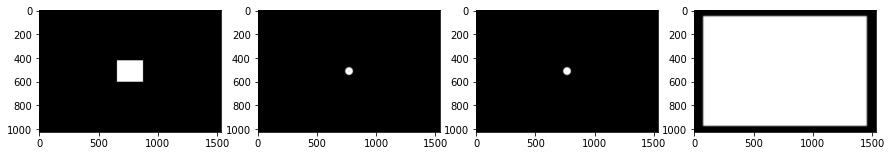

In [45]:

lamella_mask = calibration.create_lamella_mask(img, settings, factor=FACTOR, use_trench_height=False)
bandpass = calibration.bandpass_mask((img.data.shape[1], img.data.shape[0]))
circ_mask = calibration.circ_mask((img.data.shape[1], img.data.shape[0]))
rect_mask = calibration._mask_rectangular(img.data.shape)


fig, ax = plt.subplots(1, 4, figsize=(15, 15))
ax[0].imshow(lamella_mask, cmap="gray")
ax[1].imshow(bandpass, cmap="gray")
ax[2].imshow(circ_mask, cmap="gray")
ax[3].imshow(rect_mask, cmap="gray")
plt.show()


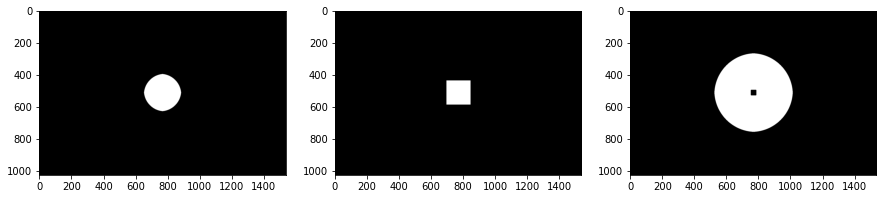

In [66]:
circ_mask_v2 = calibration.create_circle_mask(img.data.shape, radius=128)
rect_mask_v2 = calibration.create_rect_mask(img.data, w=150, h=150)
bandpass_mask_v2 = calibration.create_bandpass_mask(img.data.shape, lp=256, hp=6, sigma=3)


fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].imshow(circ_mask_v2, cmap="gray")
ax[1].imshow(rect_mask_v2, cmap="gray")
ax[2].imshow(bandpass_mask_v2, cmap="gray")
plt.show()

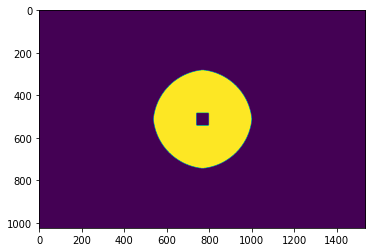

In [60]:
plt.imshow(bandpass_mask_v2)
plt.show()